In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import sph_harm
from mpl_toolkits.basemap import Basemap

import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.ipmag as ipmag


%matplotlib inline
%config InlineBackend.figure_formats = {'retina',}

In [2]:
gauss_coef = pd.read_csv('source/gauss_coefs_Qt10.dat', skiprows=2, delim_whitespace=True, dtype='float')

In [3]:
gauss_coef.head()

,t_step,time,h1_1,g1_0,g1_1,h2_2,h2_1,g2_0,g2_1,g2_2,h3_3,h3_2,h3_1,g3_0,g3_1,g3_2,g3_3
0,3000100.0,1.50005,0.005862,0.062676,-0.001192,-0.000302,0.001697,0.001378,-0.001335,0.000350,-0.000125,0.000554,-0.000740,0.001768,0.000294,0.000421,0.000094
1,3000200.0,1.50010,0.005872,0.062682,-0.001177,-0.000298,0.001697,0.001378,-0.001338,0.000350,-0.000132,0.000556,-0.000739,0.001767,0.000288,0.000423,0.000094
2,3000300.0,1.50015,0.005881,0.062688,-0.001163,-0.000294,0.001697,0.001378,-0.001340,0.000351,-0.000138,0.000558,-0.000738,0.001765,0.000282,0.000425,0.000095
3,3000400.0,1.50020,0.005889,0.062694,-0.001149,-0.000291,0.001697,0.001375,-0.001342,0.000351,-0.000145,0.000560,-0.000738,0.001764,0.000278,0.000427,0.000096
4,3000500.0,1.50025,0.005897,0.062699,-0.001135,-0.000288,0.001698,0.001370,-0.001344,0.000352,-0.000151,0.000561,-0.000738,0.001763,0.000274,0.000429,0.000098


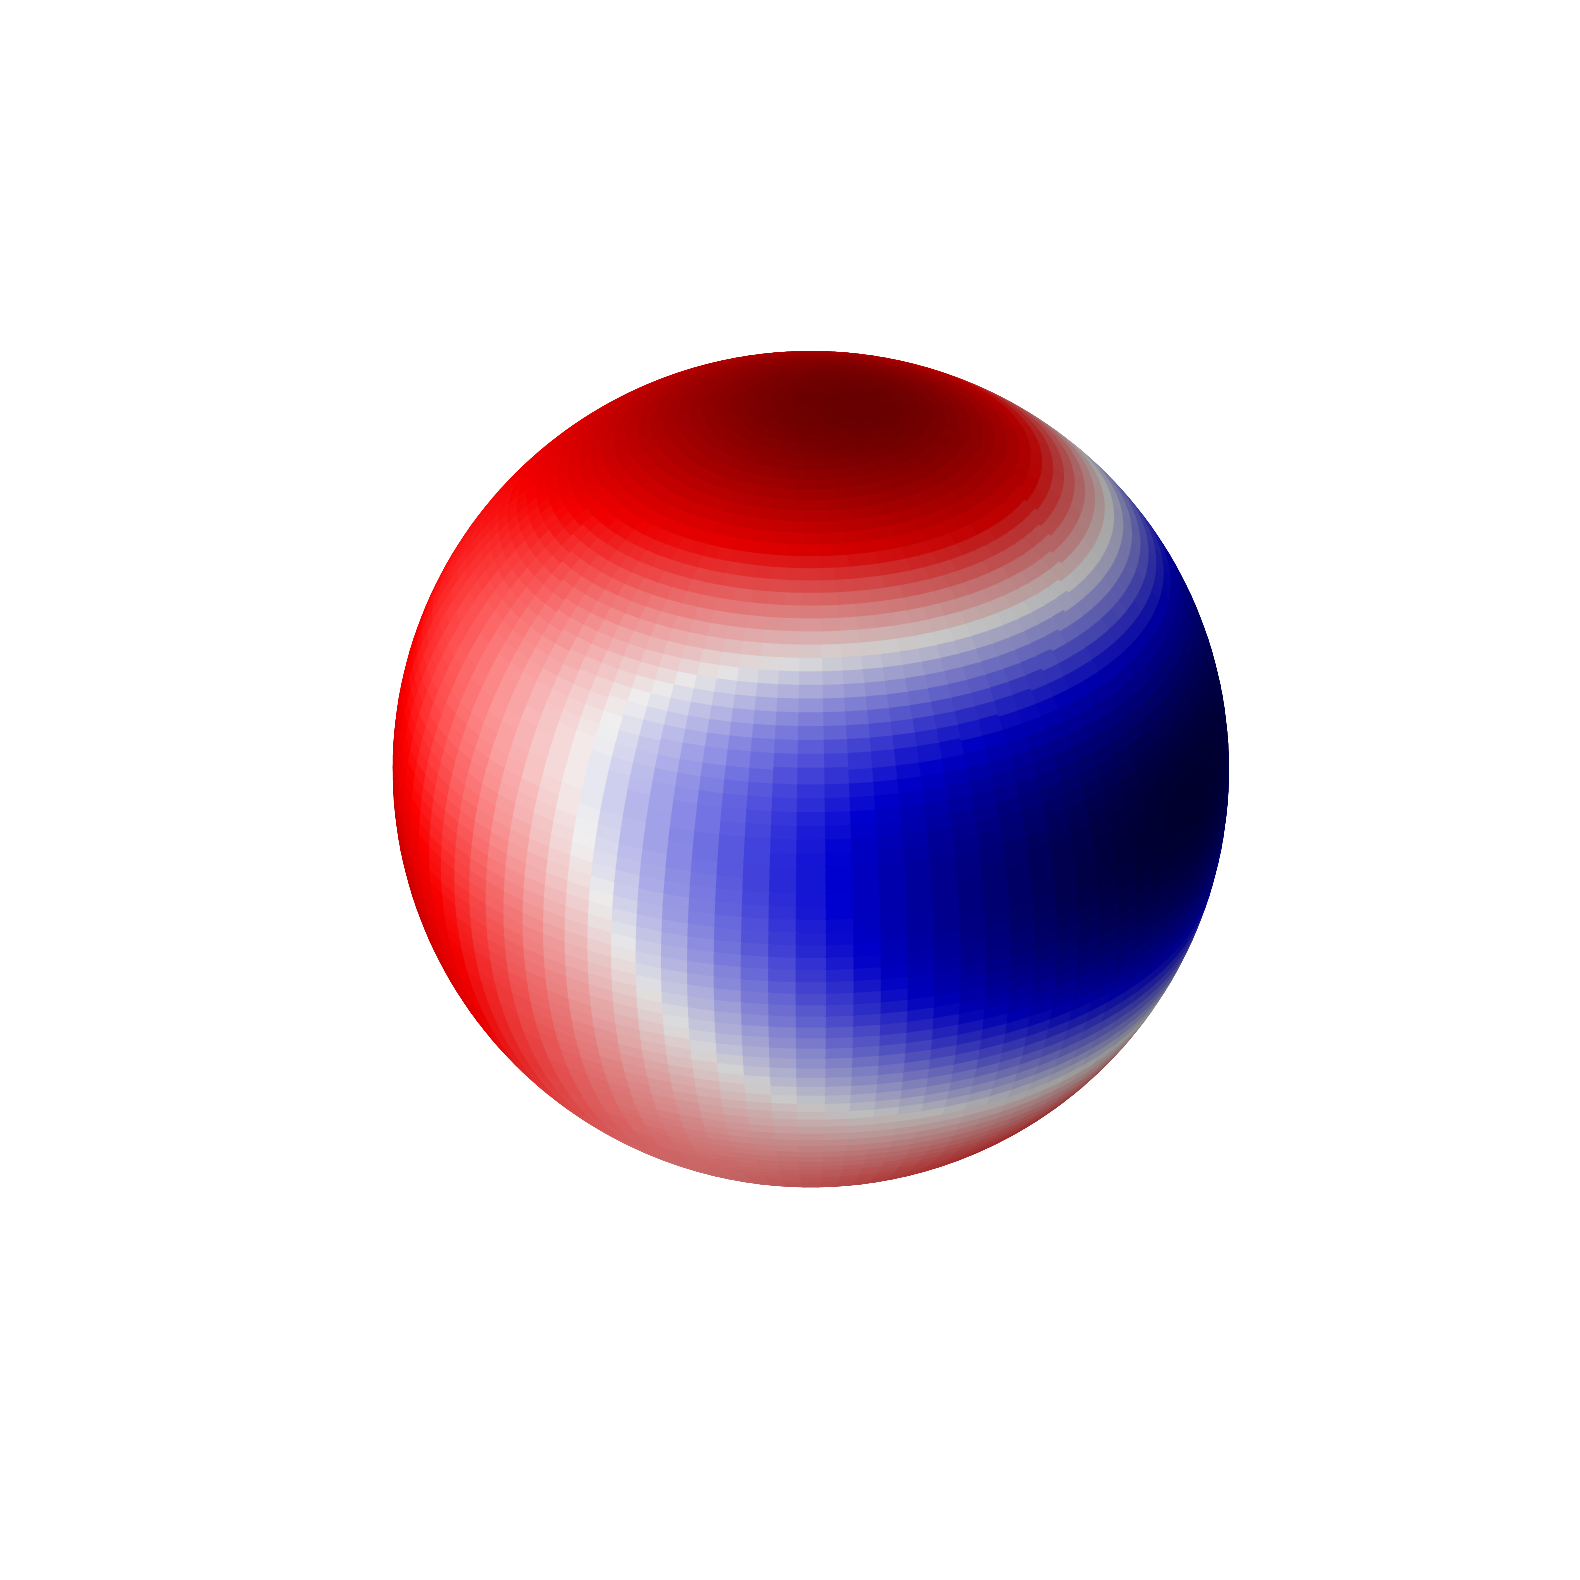

In [5]:
phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2*np.pi, 100)
phi, theta = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

try:
    del fcolors
except:
    pass

for (l, m) in [(1, 1), (2, 2), (2, 1), (2, 0), (3, 3), (3, 2), (3, 1), (3, 0)]:#, (1, 0)
    g_coef = gauss_coef['g{0}_{1}'.format(l, m)].tolist()
    try:
        h_coef = gauss_coef['h{0}_{1}'.format(l, m)].tolist()
    except:
        h_coef = [0]*len(g_coef)
    try:
        fcolors += (g_coef[0]*np.cos(m*phi)+h_coef[0]*np.sin(m*phi))*sph_harm(m, l, theta, phi).real
    except:
        fcolors = (g_coef[0]*np.cos(m*phi)+h_coef[0]*np.sin(m*phi))*sph_harm(m, l, theta, phi).real
fmax, fmin = fcolors.max(), fcolors.min()
fcolors = (fcolors - fmin)/(fmax - fmin)

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.seismic(fcolors))
# Turn off the axis planes
ax.set_axis_off()
# plt.title('m={0}, n={1}'.format(m,l), fontsize='x-large', position=(0.5,0.86))
plt.tight_layout()
# plt.savefig('sph_harm_m{0}_n{1}.pdf'.format(m,l))
plt.show()

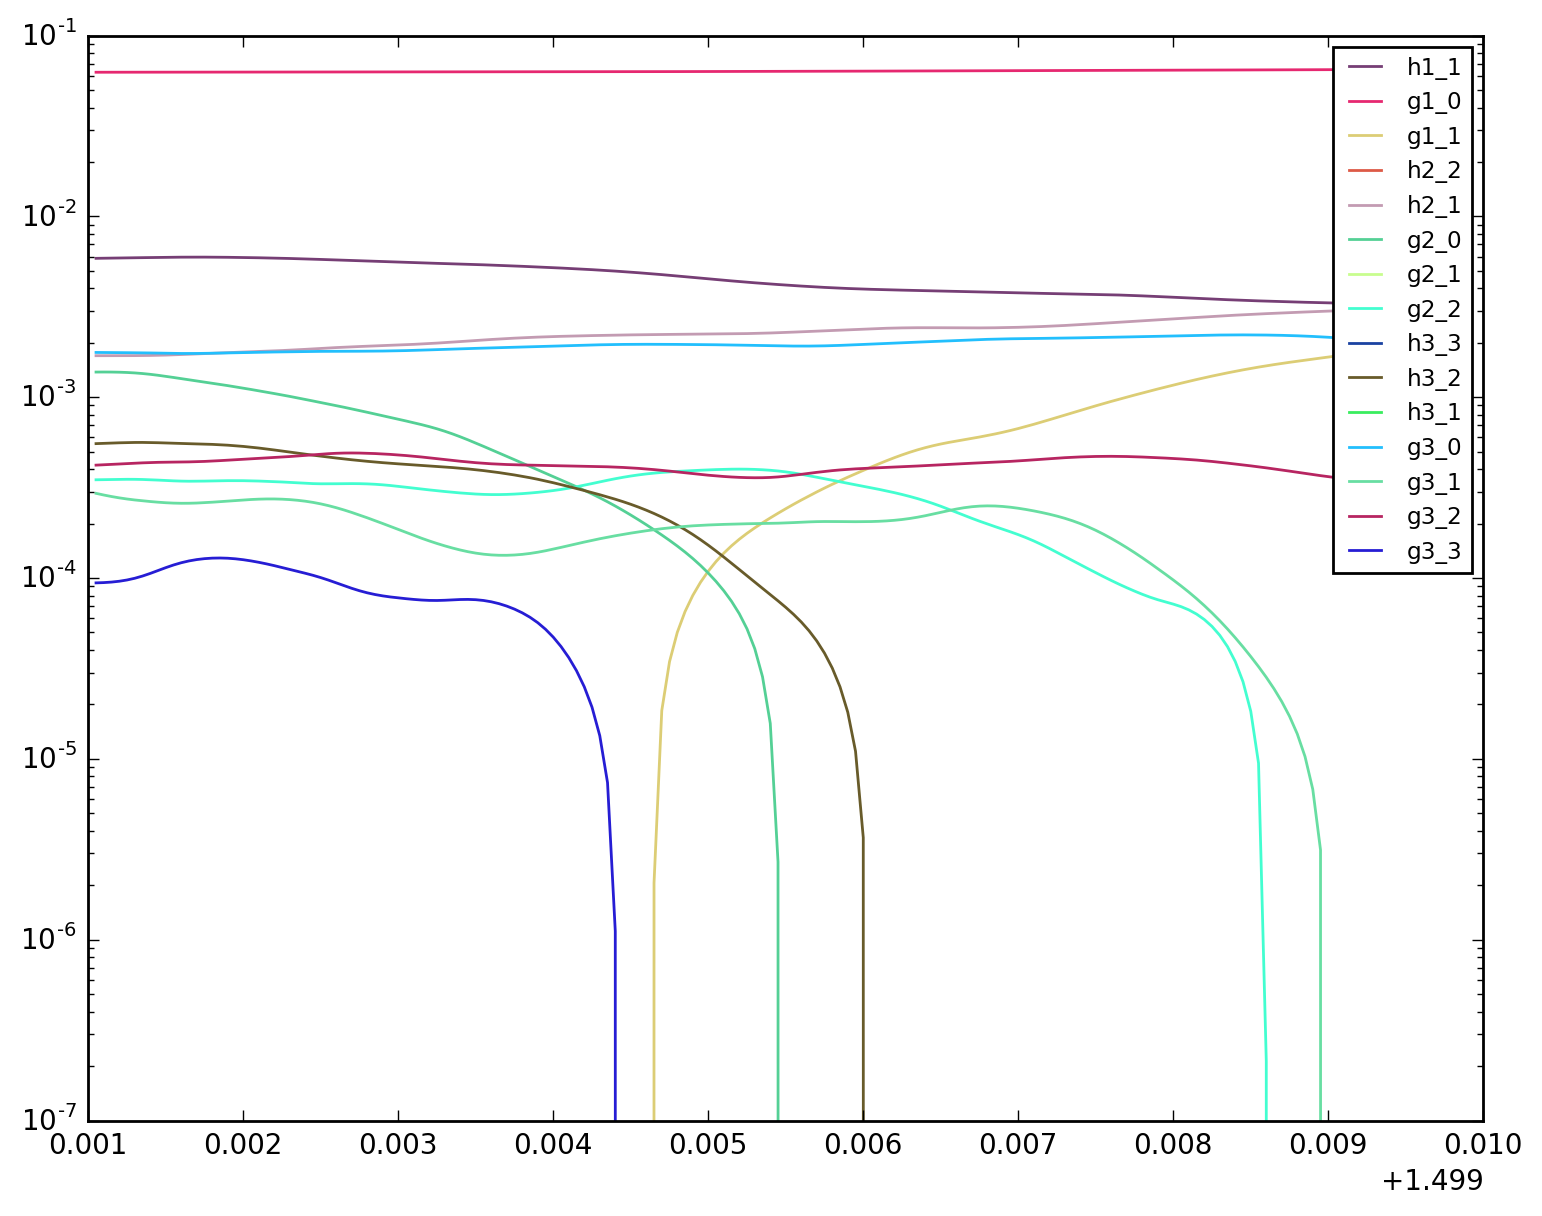

In [6]:
plt.figure(figsize=(9,7))
for column in gauss_coef.columns[2:].tolist():
    plt.plot(gauss_coef.time.tolist(), gauss_coef[column].tolist(), c = np.random.rand(3), label=column)
plt.legend(fontsize='small')
plt.yscale('log')
# plt.xlim(gauss_coef.time.min(), gauss_coef.time.max())
plt.savefig('gauss_coef_plot.pdf')
plt.show()

In [7]:
gauss_coef_trimmed = gauss_coef[gauss_coef.columns[1:].tolist()]
gauss_coef_trimmed.set_index('time', inplace=True)

In [8]:
by_pole = pd.DataFrame(columns=['time', 'dipole', 'quadrupole', 'octupole'])

In [9]:
for i in range(len(gauss_coef_trimmed)):
    time_index = gauss_coef_trimmed.index[i]
    by_pole.set_value(i, 'time', time_index)
    by_pole.set_value(i, 
                      'dipole', 
                      np.sqrt((gauss_coef_trimmed.h1_1[time_index])**2 + 
                              (gauss_coef_trimmed.g1_0[time_index])**2 + 
                              (gauss_coef_trimmed.g1_1[time_index])**2))
    by_pole.set_value(i, 
                      'quadrupole', 
                      np.sqrt((gauss_coef_trimmed.h2_2[time_index])**2 + 
                              (gauss_coef_trimmed.h2_1[time_index])**2 + 
                              (gauss_coef_trimmed.g2_0[time_index])**2 + 
                              (gauss_coef_trimmed.g2_1[time_index])**2 + 
                              (gauss_coef_trimmed.g2_2[time_index])**2))
    by_pole.set_value(i, 
                      'octupole', 
                      np.sqrt((gauss_coef_trimmed.h3_3[time_index])**2 + 
                              (gauss_coef_trimmed.h3_2[time_index])**2 + 
                              (gauss_coef_trimmed.h3_1[time_index])**2 + 
                              (gauss_coef_trimmed.g3_0[time_index])**2 + 
                              (gauss_coef_trimmed.g3_1[time_index])**2 + 
                              (gauss_coef_trimmed.g3_2[time_index])**2 + 
                              (gauss_coef_trimmed.g3_3[time_index])**2))

In [8]:
by_pole.set_index(['time'], inplace=True)

In [9]:
by_pole.head()

,dipole,quadrupole,octupole
time,,,
1.25005,0.0206125,0.000454623,0.000559331
1.25010,0.0206116,0.000453118,0.000559292
1.25015,0.0206107,0.000451617,0.000559229
1.25020,0.02061,0.00045012,0.000559117
1.25025,0.0206093,0.000448614,0.000558921


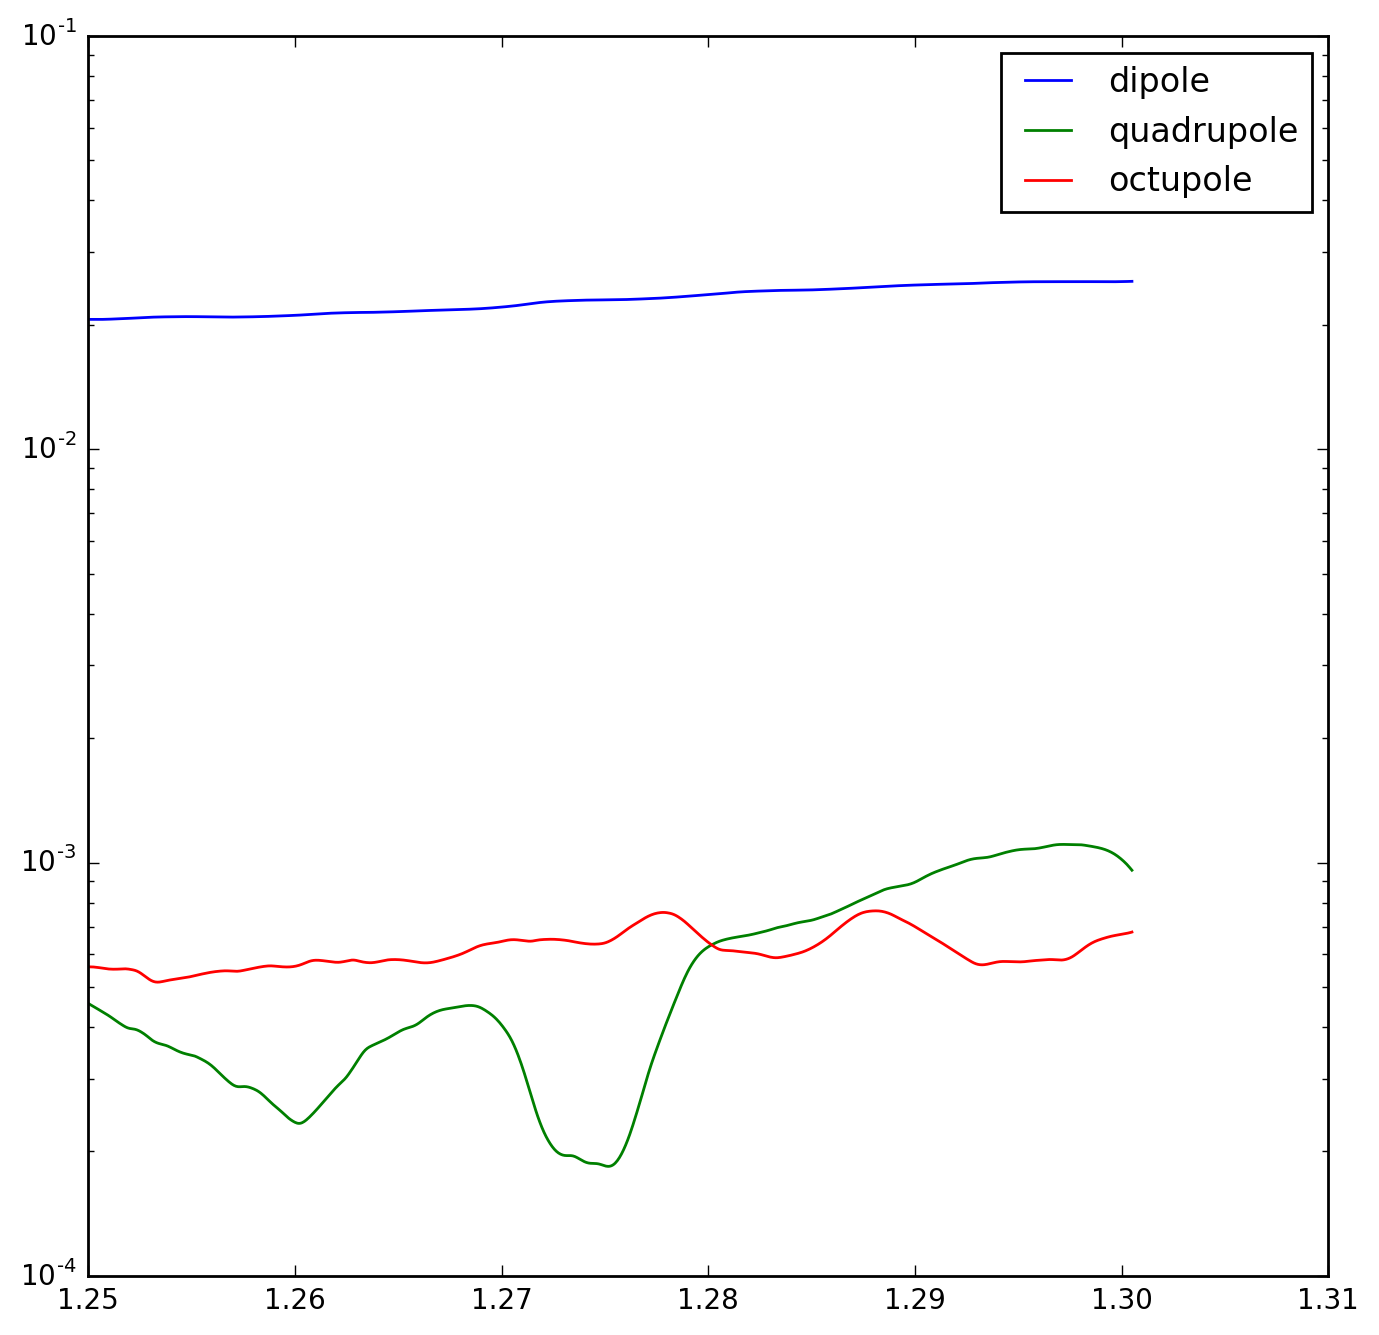

In [10]:
plt.figure(figsize=(8,8))
plt.plot(by_pole.index.tolist(), by_pole.dipole.tolist(), label='dipole')
plt.plot(by_pole.index.tolist(), by_pole.quadrupole.tolist(), label='quadrupole')
plt.plot(by_pole.index.tolist(), by_pole.octupole.tolist(), label='octupole')
plt.yscale('log')
plt.legend()
plt.show()

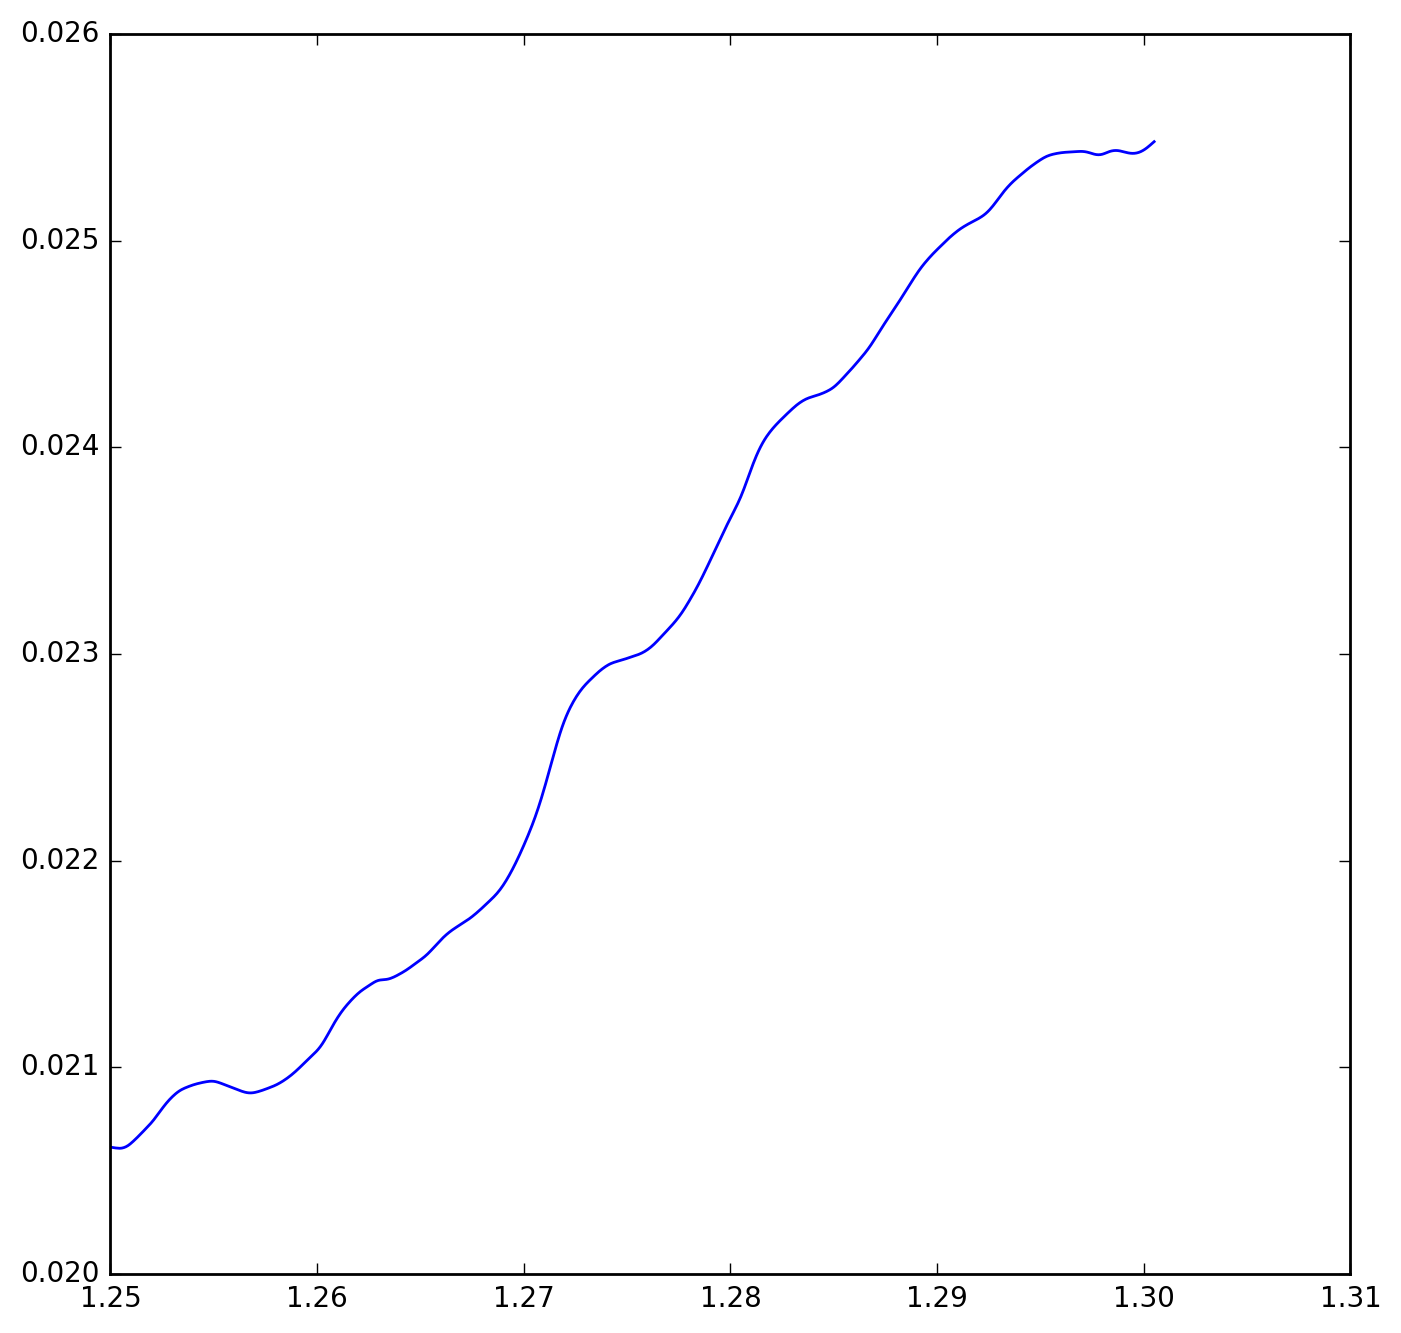

In [11]:
plt.figure(figsize=(8,8))
plt.plot(by_pole.index.tolist(), by_pole.dipole.tolist(), label='dipole')
plt.show()

In [12]:
gauss_coef

,t_step,time,h1_1,g1_0,g1_1,h2_2,h2_1,g2_0,g2_1,g2_2,h3_3,h3_2,h3_1,g3_0,g3_1,g3_2,g3_3
0,2500100.0,1.25005,-0.000081,0.020612,-0.000066,0.000204,-0.000036,-0.000063,-0.000363,0.000167,0.000025,0.000072,-0.000061,-0.000537,-0.000018,0.000103,0.000067
1,2500200.0,1.25010,-0.000081,0.020611,-0.000066,0.000204,-0.000034,-0.000064,-0.000361,0.000167,0.000025,0.000071,-0.000061,-0.000537,-0.000017,0.000103,0.000067
2,2500300.0,1.25015,-0.000080,0.020610,-0.000066,0.000203,-0.000032,-0.000065,-0.000360,0.000167,0.000025,0.000070,-0.000061,-0.000537,-0.000017,0.000102,0.000067
3,2500400.0,1.25020,-0.000080,0.020610,-0.000066,0.000203,-0.000030,-0.000066,-0.000358,0.000167,0.000025,0.000069,-0.000061,-0.000537,-0.000016,0.000102,0.000067
4,2500500.0,1.25025,-0.000080,0.020609,-0.000065,0.000203,-0.000029,-0.000066,-0.000357,0.000167,0.000025,0.000068,-0.000061,-0.000537,-0.000015,0.000101,0.000066
5,2500600.0,1.25030,-0.000080,0.020609,-0.000065,0.000202,-0.000028,-0.000067,-0.000355,0.000167,0.000025,0.000067,-0.000061,-0.000537,-0.000015,0.000101,0.000066
6,2500700.0,1.25035,-0.000079,0.020608,-0.000065,0.000202,-0.000027,-0.000068,-0.000353,0.000167,0.000026,0.000066,-0.000061,-0.000537,-0.000014,0.000101,0.000066
7,2500800.0,1.25040,-0.000079,0.020608,-0.000065,0.000201,-0.000026,-0.000069,-0.000351,0.000167,0.000026,0.000064,-0.000062,-0.000537,-0.000014,0.000100,0.000066
8,2500900.0,1.25045,-0.000079,0.020607,-0.000065,0.000201,-0.000026,-0.000069,-0.000349,0.000167,0.000026,0.000063,-0.000062,-0.000536,-0.000013,0.000100,0.000066
9,2501000.0,1.25050,-0.000079,0.020608,-0.000065,0.000201,-0.000026,-0.000070,-0.000347,0.000167,0.000026,0.000062,-0.000062,-0.000536,-0.000013,0.000100,0.000066


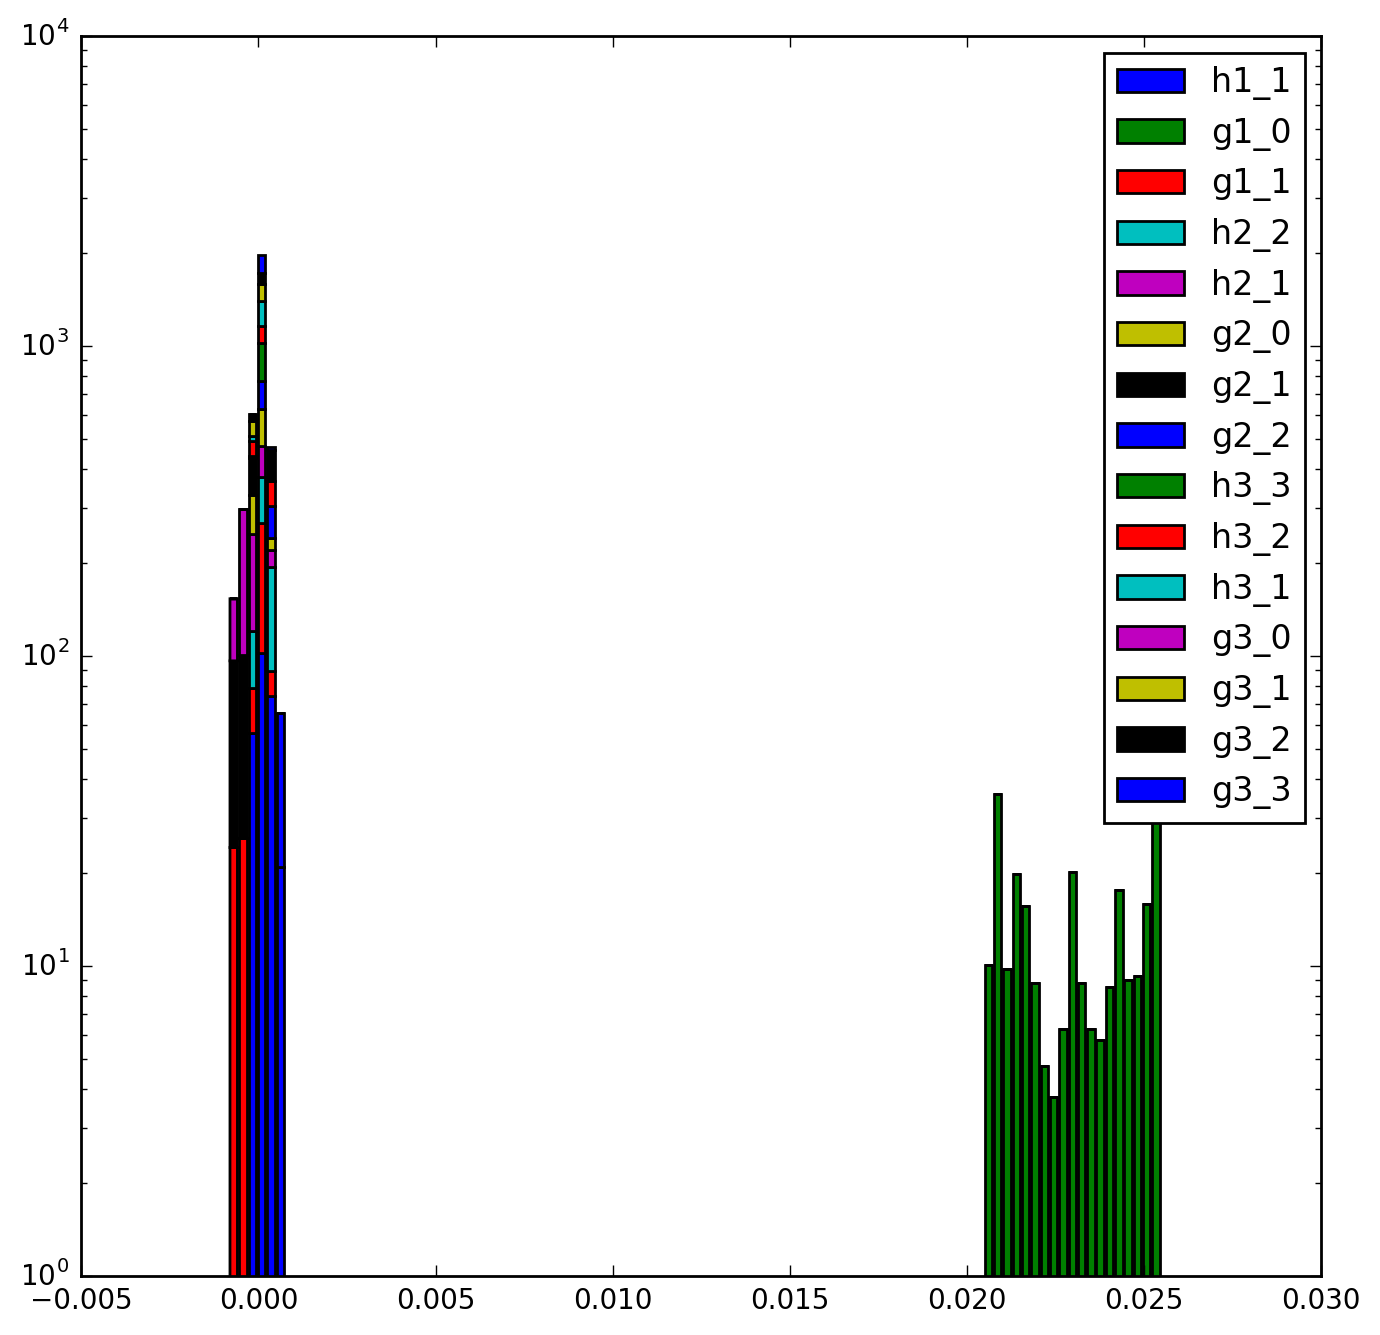

In [13]:
plt.figure(figsize=(8,8))
plt.hist(np.array(gauss_coef_trimmed), bins=100, log=True, stacked=True, normed=True, label=gauss_coef_trimmed.columns.tolist())
plt.legend()
plt.show()

In [4]:
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import pmagpy.pmagplotlib as pmagplotlib

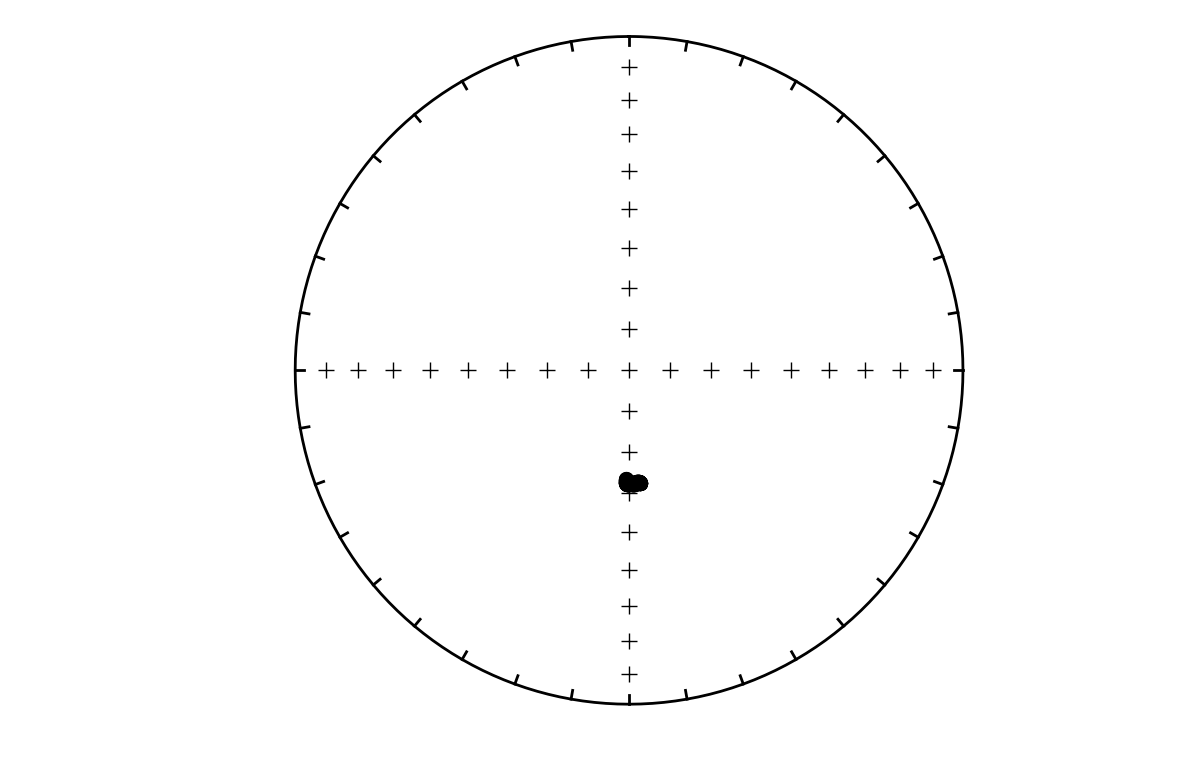

In [5]:
plt.figure(1)
ipmag.plot_net(1)
for i in range(len(gauss_coef)):
    time_step = list(gauss_coef.ix[i, ['g1_0', 'g1_1', 'h1_1', 'g2_0', 'g2_1', 'h2_1', 'g2_2', 'h2_2', 'g3_0', 'g3_1', 'h3_1', 'g3_2', 'h3_2', 'g3_3', 'h3_3']]*1000)
    block = list(pmag.getvec(time_step,-45, 180))
#     print "dec = ", block[0]
#     print "inc = ", block[1]
    ipmag.plot_di(block[0], block[1])
plt.show()

In [16]:
gauss_coef = gauss_coef.ix[gauss_coef['t_step']<=3015000.0]

In [17]:
vgps = pd.DataFrame(columns=['dec', 'inc', 'site_lat', 'site_lon', 'vgp_lat', 'vgp_lon'])
mean_poles = pd.DataFrame(columns=['site_lat', 'site_lon', 'mean_pole_lat', 'mean_pole_lon', 'actual_pole_lat', 'actual_pole_lon'])

In [18]:
def pole_figure_appearance(size = (7,7), center_lat = 35, center_lon = 200):
    m = Basemap(projection='ortho',lat_0=center_lat,lon_0=center_lon,resolution='c',
                area_thresh=50000)
    plt.figure(figsize=size)
    m.drawcoastlines(linewidth=0.25)
    m.fillcontinents(color='bisque',lake_color='white',zorder=1)
    m.drawmapboundary(fill_color='white')
    m.drawmeridians(np.arange(0,360,30))
    m.drawparallels(np.arange(-90,90,30))
    return m

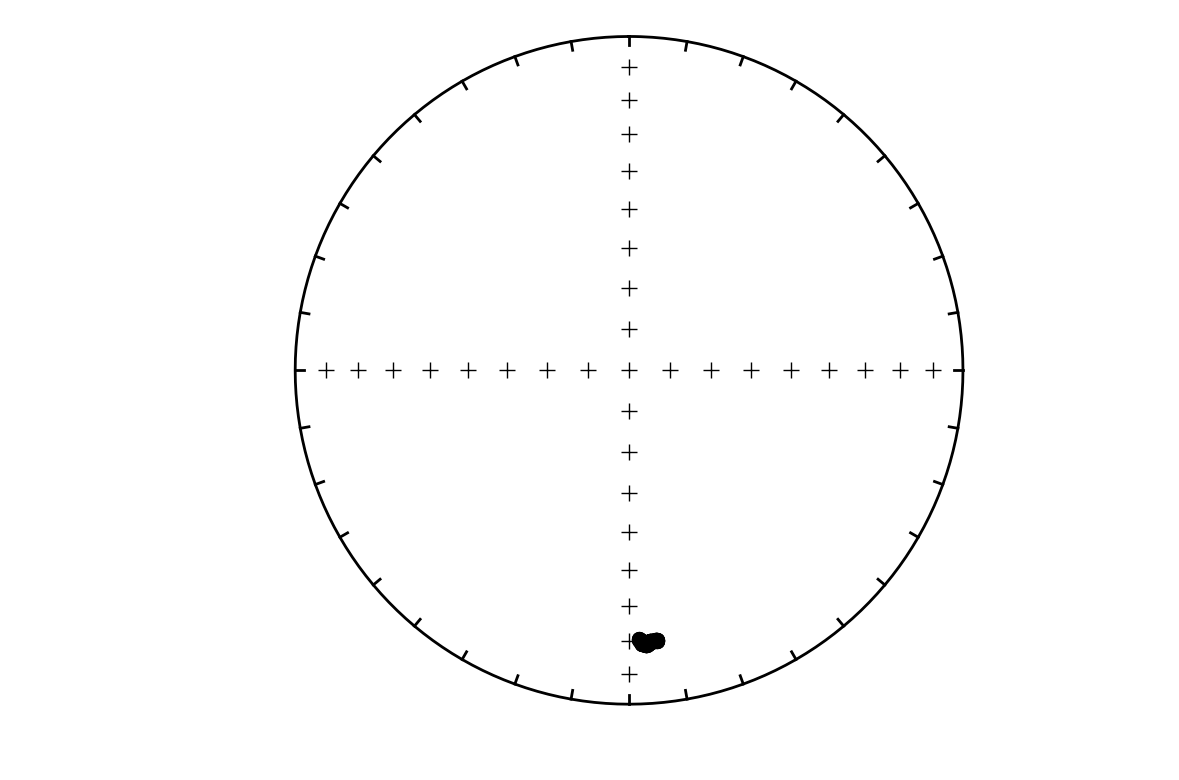

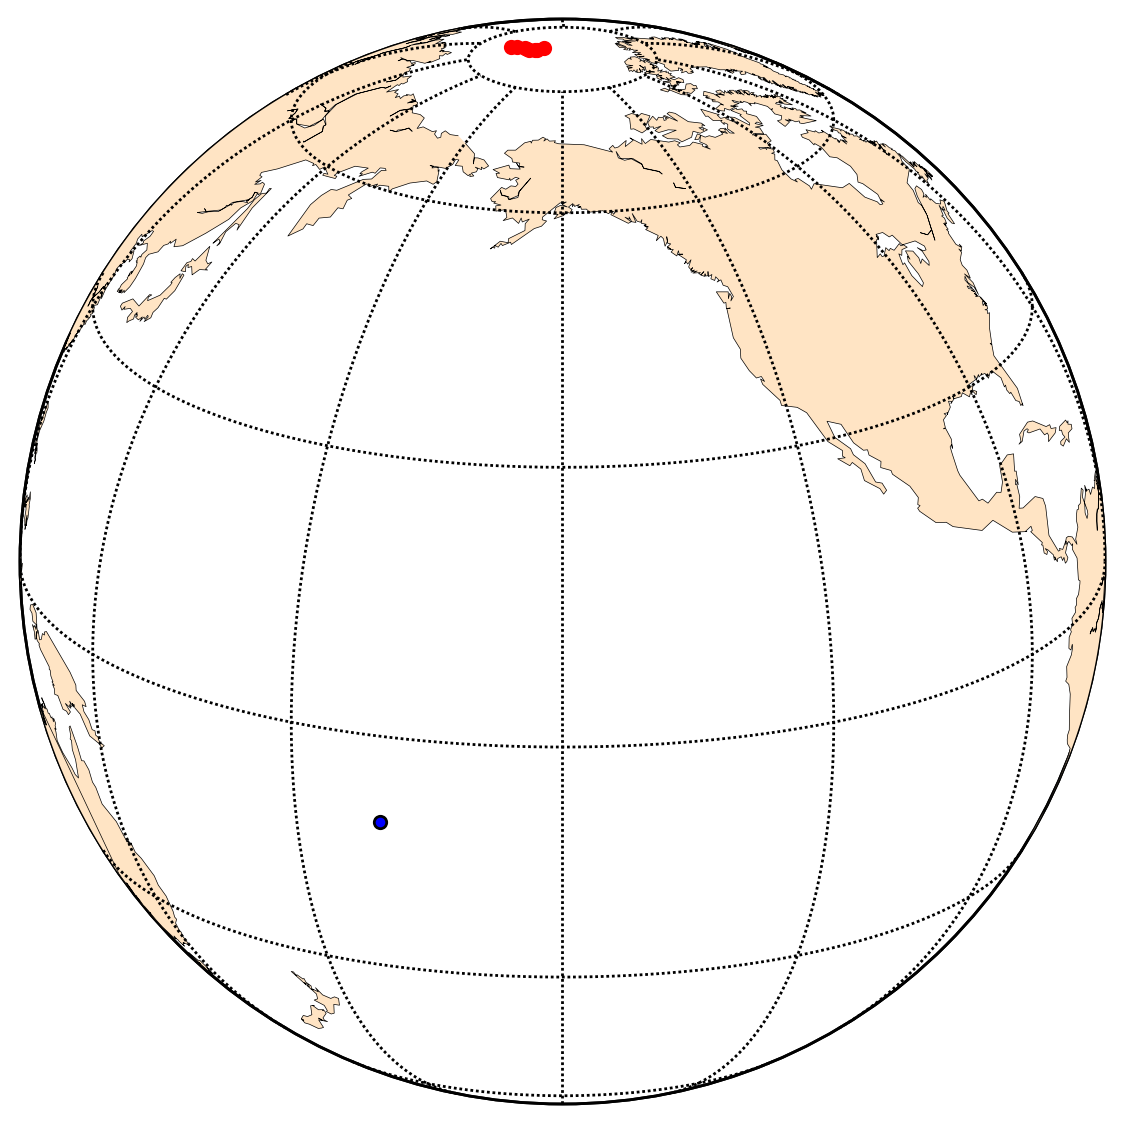

In [19]:
lat=-10
lon = 190

plt.figure(1)
ipmag.plot_net(1)
dec_list = []
inc_list = []
lat_list = []
lon_list = []
for i in range(len(gauss_coef)):
    g_coefs = list(gauss_coef.ix[i, ['g1_0', 'g1_1', 'h1_1', 'g2_0', 'g2_1', 'h2_1', 'g2_2', 'h2_2', 'g3_0', 'g3_1', 'h3_1', 'g3_2', 'h3_2', 'g3_3', 'h3_3']])
    block = list(pmag.getvec(g_coefs,lat, lon))
    ipmag.plot_di(block[0], block[1])
    dec_list.append(block[0])
    inc_list.append(block[1])
    lat_list.append(lat)
    lon_list.append(lon)
plt.show()

dirs_df = pd.DataFrame(data={'dec':dec_list, 'inc':inc_list, 'lat':lat_list, 'lon':lon_list},columns=['dec', 'inc', 'lat', 'lon'])
ipmag.vgp_calc(dirs_df, site_lat='lat', site_lon='lon', dec_tc='dec', inc_tc='inc')
#simulate 8 samples from distribution
sampled_dirs_dec = []
sampled_dirs_inc = []
sampled_dirs_lon = []
sampled_dirs_lat = []
for j in range(8):
    if j==0:
        rand_index = np.random.randint(0, len(gauss_coef)//8)
    else:
        rand_index = np.random.randint(j*len(gauss_coef)//8, (j+1)*len(gauss_coef)//8)
    sampled_dirs_dec.append(dirs_df['dec'].tolist()[rand_index])
    sampled_dirs_inc.append(dirs_df['inc'].tolist()[rand_index])
    sampled_dirs_lon.append(dirs_df['vgp_lon_rev'].tolist()[rand_index])
    sampled_dirs_lat.append(dirs_df['vgp_lat_rev'].tolist()[rand_index])
    
m = pole_figure_appearance(center_lat=20, center_lon=-150)

actual_pole = ipmag.fisher_mean(dirs_df['vgp_lon_rev'].tolist(), dirs_df['vgp_lat_rev'].tolist())

mean_pole = ipmag.fisher_mean(sampled_dirs_lon, sampled_dirs_lat)
# ipmag.plot_vgp(m,dirs_df['vgp_lon_rev'].tolist(),dirs_df['vgp_lat_rev'].tolist())
ipmag.plot_vgp(m,sampled_dirs_lon, sampled_dirs_lat, color='r')
# ipmag.plot_pole(m, mean_pole['dec'], mean_pole['inc'], mean_pole['alpha95'], marker='s')
m.scatter(lon, lat, latlon=True)
# plt.savefig('sink_VGPS.pdf')
plt.show()

vgps = vgps.append(pd.Series(data = {'dec':sampled_dirs_dec, 'inc':sampled_dirs_inc, 
                              'site_lat':lat, 'site_lon':lon, 
                              'vgp_lat':sampled_dirs_lat, 'vgp_lon':sampled_dirs_lon}), ignore_index=True)
mean_poles = mean_poles.append(pd.Series(data = {'site_lat':lat, 'site_lon':lon, 
                             'mean_pole_lat':mean_pole['inc'], 
                             'mean_pole_lon':mean_pole['dec'], 
                             'actual_pole_lat':actual_pole['inc'], 
                             'actual_pole_lon':actual_pole['dec']}), ignore_index=True)

In [12]:
vgps

,dec,inc,site_lat,site_lon,vgp_lat,vgp_lon
0,"[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]",-10.0,190.0,"[nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan]"
1,"[177.423941168, nan, nan, nan, nan, nan, nan, ...","[19.7137784437, nan, nan, nan, nan, nan, nan, ...",-10.0,190.0,"[87.4588200546, nan, nan, nan, nan, nan, nan, ...","[96.2231739927, nan, nan, nan, nan, nan, nan, ..."


In [13]:
g_coefs

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]